# Convolutional Neural Networks:
## Setup:
1. Start by downloading the [homNIST dataset](https://www.kaggle.com/datasets/lachlanemacdonald/homnist) and then put it in your google drive folder.
2. Then go to the left panel and click on the icon of a folder with the google drive's triangle in front of it.
3. Wait for it to load and then proceed with the rest of the notebook

In [ ]:
'''
This Cell unzips the homNIST dataset into the local drive.
If you didn't change the dataset's name it should be called "archive(1).zip
and be on the drive/MyDrive folder.
'''

import zipfile
archive = zipfile.ZipFile('drive/MyDrive/archive(1).zip')

for file in archive.namelist():
        archive.extract(file, '.')

In [ ]:
'''
Now let's check the dataset. If you read the description of the dataset in the 
kagglee page, you'll see that it says that it is a dictionary and you can load 
the .mat file with the loadmat function from scipy.io library.

Let's explore the dataset
'''


import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt

mnist = loadmat('homNIST_test.mat')
mnist['img_data'].astype(np.float32)
list(mnist.keys())

['__header__',
 '__version__',
 '__globals__',
 'img_data',
 'labels',
 'hom_matrices']

In [ ]:
mnist['img_data'].shape

(320000, 40, 40)

In [ ]:
mnist['labels'].shape

(320000, 1)

In [ ]:
mnist['hom_matrices'].shape

(320000, 3, 3)

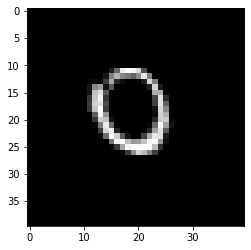

In [ ]:
plt.figure()
plt.imshow(mnist['img_data'][0,:,:], cmap='gray')
plt.show()

In [ ]:
'''
Here something called list comprehension is used to find the first example
of each of the 10 digits (from 0 to 1).

You can google "python list comprehension" to get a more in depth understanding
of what this kind of syntax does
'''

first_digits = [np.argmax(mnist['labels']==i) for i in range(10)]
first_digits

[0, 32, 64, 128, 192, 288, 256, 96, 224, 160]

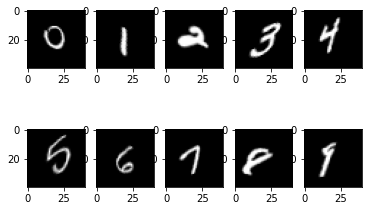

In [ ]:
fig, axs = plt.subplots(2,5)

for i,v in enumerate(first_digits):
    if i<5:
        axs[0][i].imshow(mnist['img_data'][v,:,:], cmap='gray')
    else:
        axs[1][i-5].imshow(mnist['img_data'][v,:,:], cmap='gray')

plt.show()

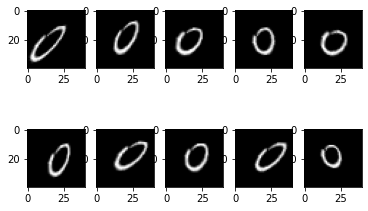

In [ ]:
'''
Here we show the first 10 examples of the digit 0.
'''

examples_0 = np.argpartition(mnist['labels']==0, 10, axis=0)[-10:].squeeze()

fig, axs = plt.subplots(2,5)

for i,v in enumerate(examples_0):
    if i<5:
        axs[0][i].imshow(mnist['img_data'][v,:,:], cmap='gray')
    else:
        axs[1][i-5].imshow(mnist['img_data'][v,:,:], cmap='gray')

plt.show()

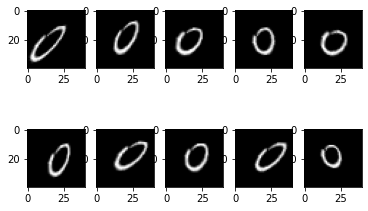

In [ ]:
'''
And here the same is done with the number 4.

Doyou know what you should to to see the first 10 examples of
the digit 4?

What about show the first 5 examples of the digit 4, and the
first 5 examples of the digit 9?
'''

examples_4 = np.argpartition(mnist['labels']==4, 10, axis=0)[-10:].squeeze()

fig, axs = plt.subplots(2,5)

for i,v in enumerate(examples_4):
    if i<5:
        axs[0][i].imshow(mnist['img_data'][v,:,:], cmap='gray')
    else:
        axs[1][i-5].imshow(mnist['img_data'][v,:,:], cmap='gray')

plt.show()

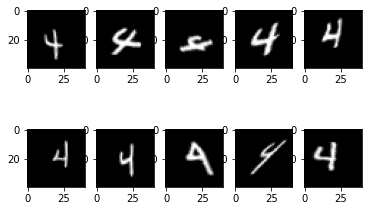

In [ ]:
examples,_ = np.nonzero(mnist['labels']==4)
examples = np.random.choice(examples, 10)

fig, axs = plt.subplots(2,5)

for i,v in enumerate(examples):
    if i<5:
        axs[0][i].imshow(mnist['img_data'][v,:,:], cmap='gray')
    else:
        axs[1][i-5].imshow(mnist['img_data'][v,:,:], cmap='gray')

plt.show()

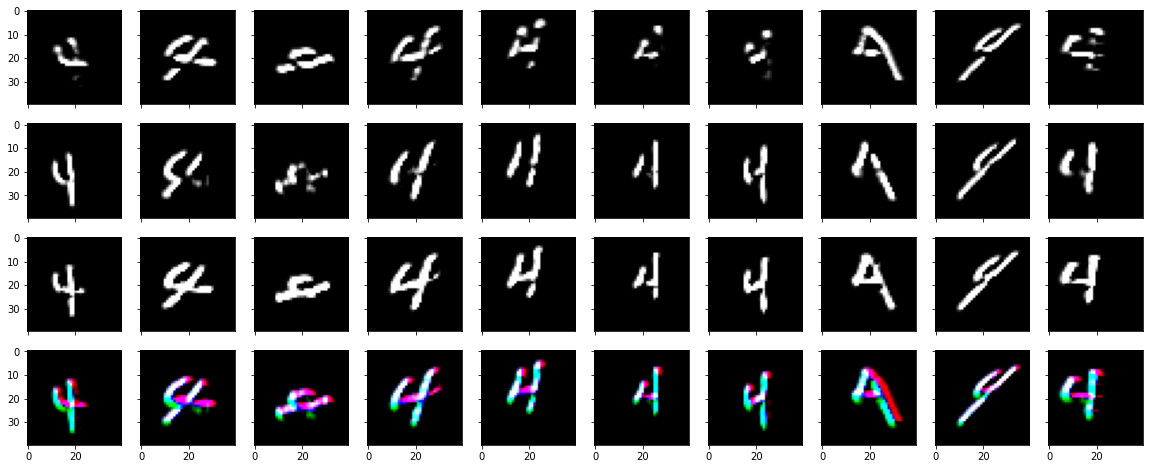

In [ ]:
'''
Now, let's use a really important library in the world of
image analysis: OpenCv.

Here the code applies 3 different convolution kernels to the 4 example digits
and then it shows waka
'''

import cv2 as cv

kernel = np.array([[-1,-2,-1],
                   [0,0,0],
                   [1,2,1]],np.float32)
out1 = [cv.filter2D(mnist['img_data'][v,:,:],-1,kernel) for v in examples]
for i,img in enumerate(out1):
    temp = img
    temp[temp<0] = 0
    temp[temp>1] = 1
    out1[i] = temp

kernel2 = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]],np.float32)
out2 = [cv.filter2D(mnist['img_data'][v,:,:],-1,kernel2) for v in examples]
for i,img in enumerate(out2):
    temp = img
    temp[temp<0] = 0
    temp[temp>1] = 1
    out2[i] = temp

    
kernel3 = np.array([[-2,-1,0],
                   [-1,1,1],
                   [-0,1,2]],np.float32)
out3 = [cv.filter2D(mnist['img_data'][v,:,:],-1,kernel3) for v in examples]
for i,img in enumerate(out3):
    temp = img
    temp[temp<0] = 0
    temp[temp>1] = 1
    out3[i] = temp


out4 = [np.stack([o1,o2,o3], axis=2) for o1,o2,o3 in zip(out1, out2, out3)]
    
fig, axs = plt.subplots(4,10, figsize=(20,8), sharex=True, sharey=True)

for i,v in enumerate(out1+out2+out3 + out4):
    if i<10:
        axs[0][i].imshow(v, cmap='gray')
    elif i<20:
        axs[1][i-10].imshow(v, cmap='gray')
    elif i<30:
        axs[2][i-20].imshow(v, cmap='gray')
    else:
        axs[3][i-30].imshow(v)

plt.show()

In [ ]:
'''
Let's create a convolutional neural network.

For this, we will use the sequential model from tensorflow. This model let's us
stack layers on top of each other sequentially.

Do you remember the Multilayer Perceptron? It's architecture was something like:

Input Layer -> Hidden Layer #1 -> Hidden Layer #2 -> ... Hidden Layer #n -> Output Layer

With tensorflow, we would create this like:

mlp_nn = keras.Sequential(
  [
    keras.Input(), # <-- Optional layer, tensorflow can infer this from input data
    layers.Dense(3), # <-- Dense layer is the name in tensorflow for standard (fully conected) layers of MLP
    layers.Dense(10), # <-- Second Hidden Layer
    layers.Dense(1), # <-- Output layer, for classifiers the size of this layer would be the amount of classes you want to identify
  ]
)


For creating a convolutional neural network, we only need to change some dense layers for convolutional ones.
Here, we will use the Conv2D type layer, but you can check the tensorflow documentation to see which other
kinds of layers there are.
'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        keras.Input(shape=(40,40,1)), # Size of our input images (40 pixels by 40 pixels and 1 color channel (B&W image))
        layers.Conv2D(
            filters=5,
            kernel_size=3,
            activation="relu"), # Convolutional Layer with ReLU activation
        layers.Conv2D(
            filters=10,
            kernel_size=3,
            activation="relu"), # Another Convolutional Layer
        layers.MaxPooling2D(3), # MaxPooling decreases resolution by getting only max values
        layers.Conv2D(
            filters=20,
            kernel_size=3,
            activation="relu"), # Last Convolutional layer
        layers.GlobalMaxPooling2D(), # Applies a global maximum
        layers.Dense(10,activation="softmax"), # The output layer with 10 neurons, one for each digit
        
    ]
)

print('------------------------------MODEL TO TRAIN----------------------------------')
print(model.summary())


------------------------------MODEL TO TRAIN----------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 38, 5)         50        
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 10)        460       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 20)        1820      
                                                                 
 global_max_pooling2d (Globa  (None, 20)               0         
 lMaxPooling2D)                                                  
                                           

In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=[layer.output for layer in model.layers],
)
# This gives us access for all the outputs in the hidden convolutional layers
# this is useful when optimizing the model (get a working model with as few parameters as possible)

print('--------------------------MODEL TO SEE FEATURES-------------------------------')
print(feature_extractor.summary())

--------------------------MODEL TO SEE FEATURES-------------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 38, 38, 5)         50        
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 10)        460       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 10)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 20)        1820      
                                                                 
 global_max_pooling2d (Globa  (None, 20)        

In [ ]:
from sklearn.model_selection import train_test_split
# The following command splits the dataset on working and testing datasets
x_train, x_test, y_train, y_test = train_test_split(mnist['img_data'],mnist['labels'])
print('Train Set Size: ', x_train.shape[0])
print('Test Set Size: ', x_test.shape[0])

Train Set Size:  240000
Test Set Size:  80000


In [ ]:
'''
The compile method let's us specify the rest of the parameters of our model.
The optimizer to use, what error function (loss) to use for optimization, and also
which performance metrics we would like to ue.

The fit method does the actual training of the model. We feed this method with the 
data and specify how the training is going to be performed.
'''

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
) 



history = model.fit(
    x_train,
    tf.squeeze(tf.one_hot(y_train,10)),
    batch_size=100,
    epochs=3,
    validation_data=(
        x_test,
        tf.squeeze(tf.one_hot(y_test,10))
    )
)

Epoch 1/3
2400/2400 [==============================] - 328s 136ms/step - loss: 0.6201 - categorical_accuracy: 0.8019 - val_loss: 0.3326 - val_categorical_accuracy: 0.8940
Epoch 2/3
2400/2400 [==============================] - 327s 136ms/step - loss: 0.2617 - categorical_accuracy: 0.9169 - val_loss: 0.2130 - val_categorical_accuracy: 0.9332
Epoch 3/3
2400/2400 [==============================] - 329s 137ms/step - loss: 0.1955 - categorical_accuracy: 0.9373 - val_loss: 0.1798 - val_categorical_accuracy: 0.9429


In [ ]:
'''
Change the variable idx below to check different outputs of the convolutional neural network.
Each plot shows how the image is being transformed layer by layer and finally shows the
actual number and the network's prediction.

idx can take values between 0 and 80000
'''

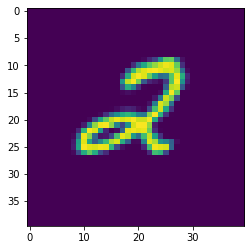

In [ ]:
idx = 5
features = feature_extractor(x_test[idx:idx+1,:,:])

plt.figure()
plt.imshow(tf.squeeze(x_test[idx:idx+1,:,:]), vmin=0, vmax=1)
plt.show()

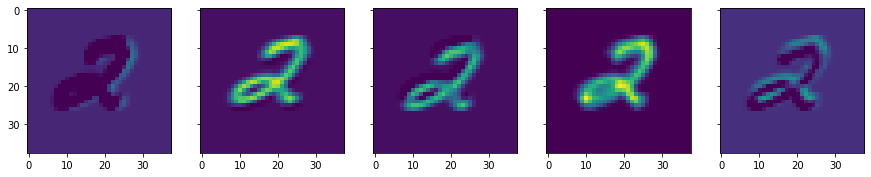

In [ ]:
layer = 0
n_maps = features[layer].shape[3]
fig, axs = plt.subplots(1,n_maps, figsize=(15,5), sharex=True, sharey=True)

for i in range(n_maps):
    axs[i].imshow(features[layer][0,:,:,i], vmin=np.min(features[layer]),vmax=np.max(features[layer]))
plt.show()

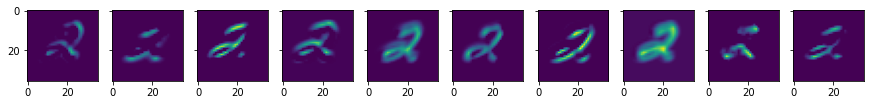

In [ ]:
layer = 1
n_maps = features[layer].shape[3]
fig, axs = plt.subplots(1,n_maps, figsize=(15,5), sharex=True, sharey=True)

for i in range(n_maps):
    axs[i].imshow(features[layer][0,:,:,i], vmin=np.min(features[layer]),vmax=np.max(features[layer]))
plt.show()

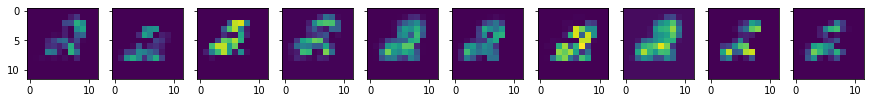

In [ ]:
layer = 2
n_maps = features[layer].shape[3]
fig, axs = plt.subplots(1,n_maps, figsize=(15,5), sharex=True, sharey=True)

for i in range(n_maps):
    axs[i].imshow(features[layer][0,:,:,i], vmin=np.min(features[layer]),vmax=np.max(features[layer]))
plt.show()

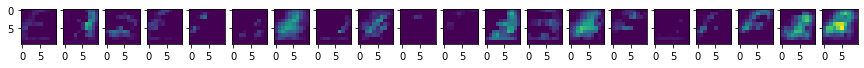

In [ ]:
layer = 3
n_maps = features[layer].shape[3]
fig, axs = plt.subplots(1,n_maps, figsize=(15,5), sharex=True, sharey=True)

for i in range(n_maps):
    axs[i].imshow(features[layer][0,:,:,i], vmin=np.min(features[layer]),vmax=np.max(features[layer]))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


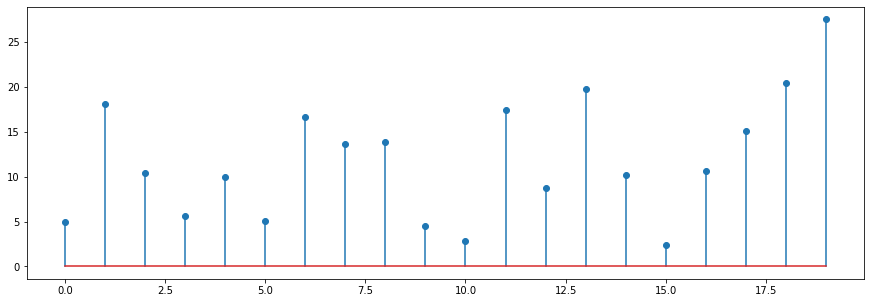

In [ ]:
plt.figure(figsize=(15,5))
plt.stem(tf.squeeze(features[4]))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


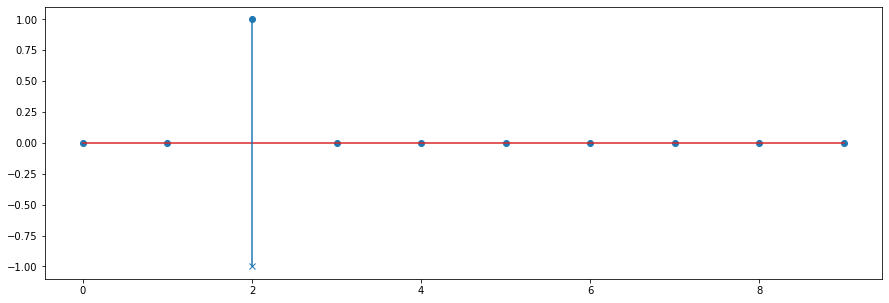

In [ ]:
plt.figure(figsize=(15,5))
plt.stem(tf.squeeze(features[5]))
plt.stem(y_test[idx], [-1], markerfmt='x')
plt.show()